In [1]:
import numpy as np
import pandas as pd
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from skimage.filters import gabor
from skimage.feature import hog

In [2]:
def getData(file):
	data = pd.read_csv(file, header=None)
	x = data.iloc[:,1:].to_numpy()
	y = data.iloc[:,0].to_numpy()
	y = np.array([int(i) for i in y])
	return x, y
 
def accuracy(y, pred):
  acc = 0
  for i in range(len(y)):
    if pred[i] == y[i]:
      acc += 1
  acc = acc/len(y)
  return acc

def ConfusionMatrix(y, pred, file):
  labels = np.unique(y)
  cm = confusion_matrix(y, pred)

  fig = plt.figure(figsize=(8,8))
  ax = fig.gca()
  _ = sns.heatmap(cm,annot=True,cmap="Blues",xticklabels=labels,yticklabels=labels,fmt='g')
  ax.set_xlabel("Actual Class")
  ax.set_ylabel("Predicted Class")
  plt.title("Confusion Matrix",y=1.08)
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')
  plt.savefig(file)
  plt.show()
  plt.close()

def gabor_features(x):
  gaborx = np.zeros(x.shape)
  for i in range(len(x)):
    real,_ = gabor(x[i].reshape((48,48)), frequency=0.6)
    gaborx[i] = real.reshape((1,2304))
  return gaborx

def hog_features(x):
  hogx = np.zeros((x.shape[0], 1296))
  for i in range(x.shape[0]):
    hogx[i] = hog(x[i].reshape(48, 48))
  return hogx

In [3]:
x_train, y_train = getData('/content/drive/MyDrive/Colab Notebooks/train.csv')
x_test, y_test = getData('/content/drive/MyDrive/Colab Notebooks/public_test.csv')
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(19376, 2304) (19376,)
(6459, 2304) (6459,)


In [4]:
gaborx_train = gabor_features(x_train)
print(gaborx_train.shape)

(19376, 2304)


In [5]:
gtx_train = torch.FloatTensor(gaborx_train).cuda()
gty_train = torch.LongTensor(y_train).cuda()
gtx_test = torch.FloatTensor(x_test.tolist()).cuda()

print(gtx_train.size())
print(gty_train.size())
print(gtx_test.size())

torch.Size([19376, 2304])
torch.Size([19376])
torch.Size([6459, 2304])


In [17]:
class NeuralNet(nn.Module):
	def __init__(self, n, h, r):
		super(NeuralNet, self).__init__()
		self.l1 = nn.Linear(n, h)
		self.relu = nn.ReLU()
		self.l2 = nn.Linear(h, r)

	def forward(self, x):
		x = self.l1(x)
		x = self.relu(x)
		x = self.l2(x)
		return F.log_softmax(x, dim=1)

	def predict(self, x):
		num_batches = int(x.shape[0]/100)
		pred = np.array([0.])
		for i in range(num_batches):
			x_batch = x[i*100:(i+1)*100]
			pred = np.concatenate((pred, torch.max(self.forward(x_batch).data, 1)[1].cpu().numpy()))
		pred = np.concatenate((pred, torch.max(self.forward(x[num_batches*100:x.shape[0]]), 1)[1].cpu().numpy()))
		return pred[1:]

	def fit(self, x, y, r, optimizer, loss_func):
		num_batches = int(x.shape[0]/r)
		converged = False
		epochs = 0
		prevloss = 0
		error = 0
		while not converged:
			for i in range(num_batches):
				x_batch = x[i*r:(i+1)*r]
				y_batch = y[i*r:(i+1)*r]
				x_var = Variable(x_batch)
				y_var = Variable(y_batch)
				optimizer.zero_grad()
				out = self.forward(x_var)
				loss = loss_func(out, y_var)
				loss.backward()
				optimizer.step()
			error = abs(prevloss - loss.data)
			prevloss = loss.data
			print('Epoch: {} - Loss: {:.6f} - Error: {:.6f}'.format(epochs, loss.data, error))
			epochs += 1
			del loss
			if epochs > 10 and error < 1e-5 or epochs > 1000:
				converged = True

In [7]:
gmodel = NeuralNet(gaborx_train.shape[1], 100, 7)
gmodel.cuda()
optimizer = optim.SGD(gmodel.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
print(gmodel)

NeuralNet(
  (l1): Linear(in_features=2304, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=7, bias=True)
)


In [8]:
start = time.time()
gmodel.fit(gtx_train, gty_train, 100, optimizer, loss_func)
end = time.time()
print('Training Time = ', (end-start))

Epoch: 0 - Loss: 1.796823 - Error: 1.796823
Epoch: 1 - Loss: 1.744266 - Error: 0.052557
Epoch: 2 - Loss: 1.690706 - Error: 0.053560
Epoch: 3 - Loss: 1.654468 - Error: 0.036238
Epoch: 4 - Loss: 1.627273 - Error: 0.027195
Epoch: 5 - Loss: 1.603572 - Error: 0.023701
Epoch: 6 - Loss: 1.583046 - Error: 0.020526
Epoch: 7 - Loss: 1.564116 - Error: 0.018929
Epoch: 8 - Loss: 1.546162 - Error: 0.017954
Epoch: 9 - Loss: 1.527038 - Error: 0.019124
Epoch: 10 - Loss: 1.507137 - Error: 0.019902
Epoch: 11 - Loss: 1.488025 - Error: 0.019112
Epoch: 12 - Loss: 1.468377 - Error: 0.019648
Epoch: 13 - Loss: 1.449832 - Error: 0.018544
Epoch: 14 - Loss: 1.431796 - Error: 0.018037
Epoch: 15 - Loss: 1.411736 - Error: 0.020059
Epoch: 16 - Loss: 1.392627 - Error: 0.019109
Epoch: 17 - Loss: 1.372700 - Error: 0.019928
Epoch: 18 - Loss: 1.351928 - Error: 0.020772
Epoch: 19 - Loss: 1.330663 - Error: 0.021265
Epoch: 20 - Loss: 1.306477 - Error: 0.024186
Epoch: 21 - Loss: 1.281680 - Error: 0.024797
Epoch: 22 - Loss: 1.

Train Accuracy =  0.9960260115606936
Macro F1 Score  =  0.9958875571950009


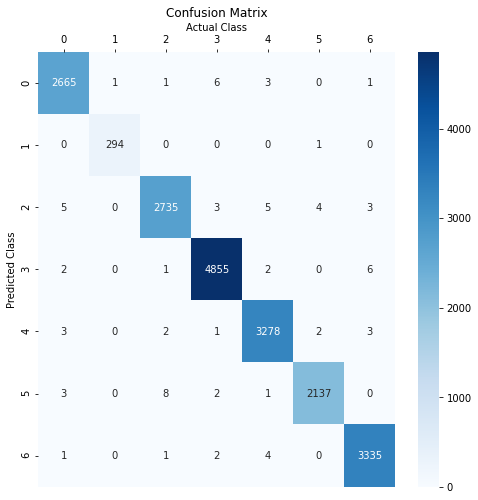

In [9]:
train_pred = gmodel.predict(gtx_train)
train_acc = accuracy(y_train, train_pred)
print("Train Accuracy = ", train_acc)
print("Macro F1 Score  = ", f1_score(y_train, train_pred, average='macro'))
ConfusionMatrix(y_train, train_pred, 'Q1btrain.png')

Test Accuracy =  0.3762192289828147
Macro F1 Score  =  0.33005894248980727


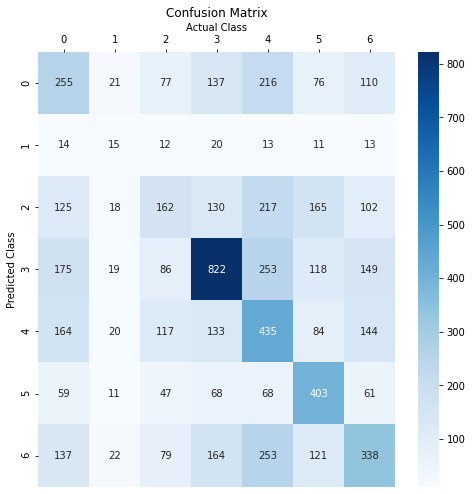

In [10]:
test_pred = gmodel.predict(gtx_test)
test_acc = accuracy(y_test, test_pred)
print("Test Accuracy = ", test_acc)
print("Macro F1 Score  = ", f1_score(y_test, test_pred, average='macro'))
ConfusionMatrix(y_test, test_pred, 'Q1btest.png')

In [11]:
hogx_train = hog_features(x_train)
print(hogx_train.shape)
hogx_test = hog_features(x_test)
print(hogx_test.shape)

(19376, 1296)
(6459, 1296)


In [12]:
htx_train = torch.FloatTensor(hogx_train.tolist()).cuda()
hty_train = torch.LongTensor(y_train.tolist()).cuda()
htx_test = torch.FloatTensor(hogx_test.tolist()).cuda()

print(htx_train.size())
print(hty_train.size())
print(htx_test.size())

torch.Size([19376, 1296])
torch.Size([19376])
torch.Size([6459, 1296])


In [18]:
hmodel = NeuralNet(hogx_train.shape[1], 100, 7)
hmodel.cuda()
optimizer = optim.SGD(hmodel.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
print(hmodel)

NeuralNet(
  (l1): Linear(in_features=1296, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=7, bias=True)
)


In [19]:
hmodel.fit(htx_train, hty_train, 100, optimizer, loss_func)

Epoch: 0 - Loss: 1.803255 - Error: 1.803255
Epoch: 1 - Loss: 1.638705 - Error: 0.164550
Epoch: 2 - Loss: 1.541208 - Error: 0.097497
Epoch: 3 - Loss: 1.505809 - Error: 0.035400
Epoch: 4 - Loss: 1.493112 - Error: 0.012697
Epoch: 5 - Loss: 1.485531 - Error: 0.007581
Epoch: 6 - Loss: 1.478084 - Error: 0.007447
Epoch: 7 - Loss: 1.469745 - Error: 0.008339
Epoch: 8 - Loss: 1.460921 - Error: 0.008824
Epoch: 9 - Loss: 1.452537 - Error: 0.008384
Epoch: 10 - Loss: 1.445951 - Error: 0.006587
Epoch: 11 - Loss: 1.440097 - Error: 0.005853
Epoch: 12 - Loss: 1.432167 - Error: 0.007930
Epoch: 13 - Loss: 1.426905 - Error: 0.005262
Epoch: 14 - Loss: 1.421499 - Error: 0.005406
Epoch: 15 - Loss: 1.415383 - Error: 0.006116
Epoch: 16 - Loss: 1.410489 - Error: 0.004894
Epoch: 17 - Loss: 1.405697 - Error: 0.004793
Epoch: 18 - Loss: 1.398993 - Error: 0.006703
Epoch: 19 - Loss: 1.393528 - Error: 0.005465
Epoch: 20 - Loss: 1.387648 - Error: 0.005881
Epoch: 21 - Loss: 1.383466 - Error: 0.004182
Epoch: 22 - Loss: 1.

Train Accuracy =  0.9944260941370768
Macro F1 Score  =  0.9938435439772065


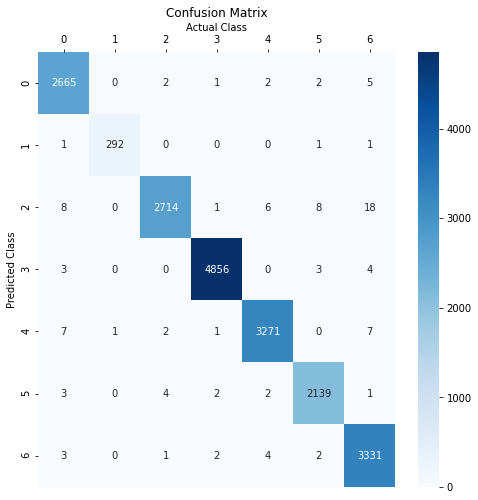

In [20]:
train_pred = hmodel.predict(htx_train)
train_acc = accuracy(y_train, train_pred)
print("Train Accuracy = ", train_acc)
print("Macro F1 Score  = ", f1_score(y_train, train_pred, average='macro'))
ConfusionMatrix(y_train, train_pred, 'Q1bhtrain.png')

Test Accuracy =  0.4384579656293544
Macro F1 Score  =  0.4101537797898665


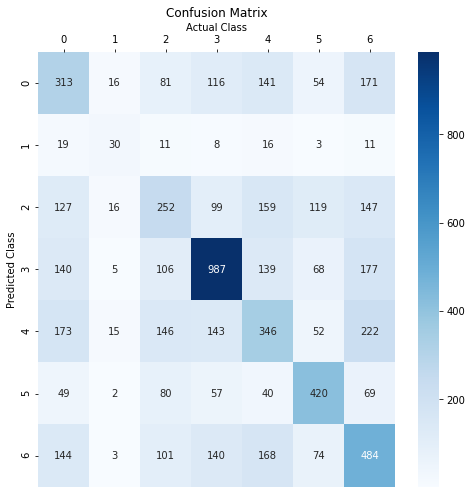

In [21]:
test_pred = hmodel.predict(htx_test)
test_acc = accuracy(y_test, test_pred)
print("Test Accuracy = ", test_acc)
print("Macro F1 Score  = ", f1_score(y_test, test_pred, average='macro'))
ConfusionMatrix(y_test, test_pred, 'Q1bhtest.png')